### Emma Klemets, 260775167   
All my work, code, output and written answers are in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simple_read_ligo import read_template, read_file
import json

In [2]:
dataLocation = "./LOSC_Event_tutorial/"

#read json file for data names
with open(dataLocation+"BBH_events_v3.json") as f:
    jdata = json.load(f)

# the event data files (32s sampled at 4096 Hz, in hdf5 format, for both LIGO detectors).
# waveform templates (32s sampled at 4096 Hz, in hdf5 format, for both plus and cross polarizations).
#data from LIGO Hanford Observatory (H1) and LIGO Livingston Observatory (L1) 

#our 4 event names
events = ["GW150914", "GW151226", "LVT151012", "GW170104"]

def getData(event):

    #reading the data
    fnameH=jdata[events[event]]['fn_H1']
    fnameL=jdata[events[event]]['fn_L1']

    print('reading file ',fnameH)
    H1=read_file(dataLocation+fnameH) #strain,dt,utc
    L1=read_file(dataLocation+fnameL)
    '''
    strain: data taken
    dt: (1.0*duration)/len(strain)
    utc: UTCstart - start of event in Coordinated Universal Time
    '''

    #reading the template
    template_name=jdata[events[event]]['fn_template']
    template =read_template(dataLocation+template_name) #th,tl

    """
    th: Hanford template
    tl: Livingston template
    """
    
    return [H1, L1, template]

reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5
0.000244140625 b'2015-09-14T09:50:30'



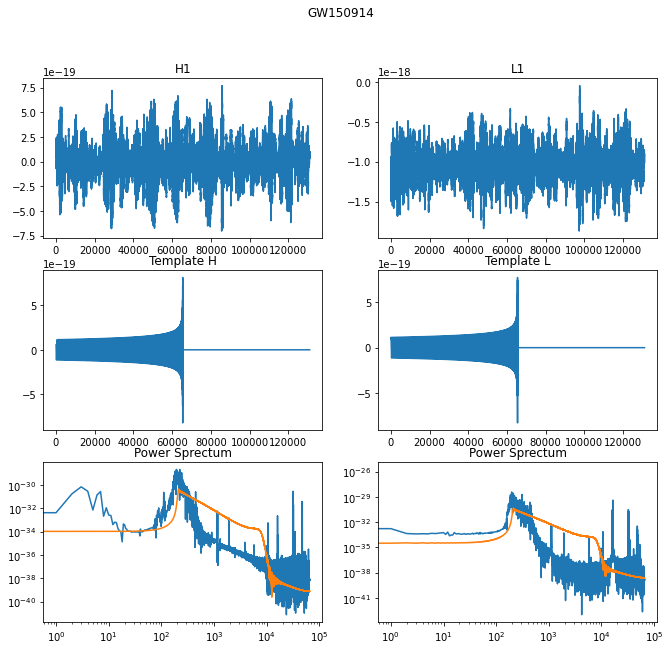

In [3]:
H1, L1, template = getData(0)
strain_H,dt_H,utc_H = H1
strain_L,dt_L,utc_L = L1
th,tl = template

#L is offset, it's centered around -1, not 0

fig, ax = plt.subplots(3, 2, figsize=(11,10))
axs = ax.flatten()

fig.suptitle(events[0])

axs[0].set_title("H1")
axs[0].plot(strain_H)
axs[1].set_title("L1")
axs[1].plot(strain_L)

print(dt_H, utc_H)

axs[2].set_title("Template H")
axs[2].plot(th)

axs[3].set_title("Template L")
axs[3].plot(tl)

axs[4].set_title("Power Sprectum")
axs[4].loglog(np.abs(np.fft.rfft(strain_H)**2))
axs[4].loglog(np.abs(np.fft.rfft(th)**2))

axs[5].set_title("Power Sprectum")
axs[5].loglog(np.abs(np.fft.rfft(strain_L)**2))
axs[5].loglog(np.abs(np.fft.rfft(tl)**2))

print()

#### a) 
Come up with a noise model for Livingston and Hanford separately. Describe in comments how you go about doing this. 
- something about how you smooth the power spectrum 
- how you deal with lines (if at all). 

Please also explain how you window the data (you may want to use a window that has an extended flat period near the center to avoid tapering the data/template where the signal is not small). 

In [4]:
def window(data, n=0, Type="cos", shift=False):
       
    if Type=="cos": #just a simple cosine window, but tapers alot of data
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        
    elif Type=="flatcos": #cosine but in center is a boxcar to avoid making signal smaller - get weird spikes from this
        x = np.linspace(-1, 1, len(data))*np.pi
        win=0.5 + 0.5*np.cos(x)
        win[n:len(data)-n]=np.max(win)
        win=win/np.sum(n) #normalize

# Tukey window, also known as the cosine-tapered window - much nicer form
    elif Type=="Tukey":
        a=n
        N = int(len(data))
        L = N+1
        n = np.arange(N)
        win = 0.5*(1-np.cos(2*np.pi*n/(a*L)))
#         print(int(a*L/2), int(N/2))
        win[int(a*L/2):int(N/2)] = 1
        win[int(N/2):] = win[::-1][int(N/2):]
        
        if shift:
            win = win + np.mean(data)
            print(np.mean(data))
    
    windowedData = win*data
    return windowedData


In [5]:
def noise(data, Type="square"): #just for now - later use fixed PS of data
    FT = np.fft.rfft(data)
    
    if Type=="square": #really the PS
        N=np.abs(FT)**2
        
        return N #noiseData

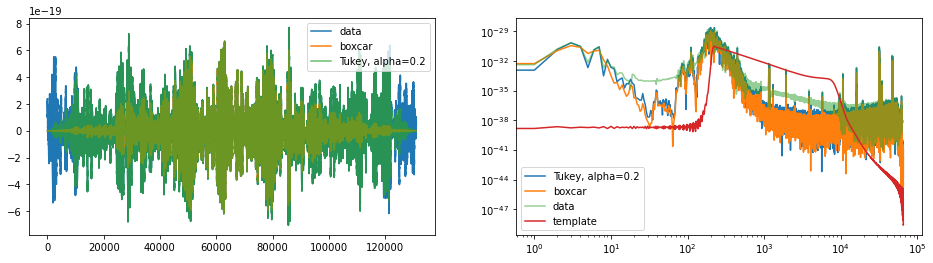

In [23]:
'''
first I want to window my data, tapering off the ends
I tried three functions for this, and the cosine-tapered window (Tukey) looked the best, 
not reducing the signal to much in the center, and still produced a similar power spectrum.
'''

fig, ax = plt.subplots(1, 2, figsize=(16,4))

alpha=0.2

strain_H_win = window(strain_H, n=alpha, Type="Tukey")

#need to window the signal as well
signal_win = window(th, n=alpha, Type="Tukey")

ax[0].plot(strain_H, label='data')
ax[0].plot(window(strain_H), label='boxcar')
ax[0].plot(window(strain_H, n=alpha, Type="Tukey"), alpha=0.7, label='Tukey, alpha={}'.format(alpha))

ax[1].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label='Tukey, alpha={}'.format(alpha))
ax[1].loglog(np.abs(np.fft.rfft(window(strain_H))**2), label='boxcar')
ax[1].loglog(np.abs(np.fft.rfft(strain_H)**2), label='data', alpha=0.5)
ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2), label='template')

ax[0].legend()
ax[1].legend()

plt.show()

In [7]:
def smooth(data, num, Type="boxcar"):
    FT = np.fft.rfft(data)
    
    if Type=="boxcar":
        sm=np.zeros(len(data))
        #set center to 1
        sm[:num]=1
        sm[-num+1:]=1
        sm=sm/np.sum(sm) #normalize
        
        smFT = np.fft.rfft(sm)
        smoothedData = np.fft.irfft(smFT*FT, len(data)) # to make sure irfft is right length
        
    if Type=="gaussian":    
        sigma = num
        x_for_k = np.arange(-100, 100)#sets how many points to smooth over
        # Calculate gaussian
        k = np.exp(-(x_for_k) ** 2 / (2 * sigma ** 2))
        # Threshold to cut off gaussian at ends
        kernel_above_thresh = k > 0.0001
        finite_kernel = k[kernel_above_thresh]
        # normalize
        finite_kernel = finite_kernel / finite_kernel.sum()
        
        smoothedData = np.convolve(data, finite_kernel, mode='same')        
    
    return smoothedData


4.669678865530346e-33 4.660359348491808e-33


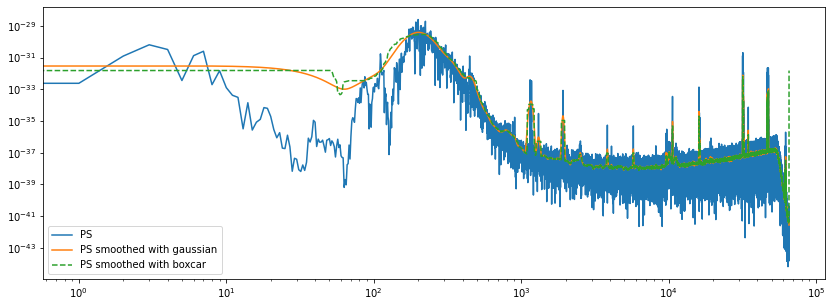

In [8]:
'''
For smoothing the noise (which is just the power spectrum of the windowed data), I decided to convolve with
a gaussian, as this averages over the data nicely, giving less sharp edges than the boxcar convolution.

'''

alpha=0.5
strain_H_win = window(strain_H, n=alpha, Type="Tukey")

H_noise = noise(strain_H_win)
signal_win = window(th, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

#gaussian
H_noise_gau = smooth(H_noise, 20, 'gaussian')

print(np.mean(H_noise), np.mean(H_noise_gau))

plt.figure(figsize=(14,5))
plt.loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
plt.loglog(H_noise_gau, label="PS smoothed with gaussian")

plt.loglog(smooth(H_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")

#this makes it worse, so maybe not
# plt.loglog(np.maximum(H_noise, H_noise_gau), ls="--", label="max of PS smoothed with boxcar")

plt.legend()
plt.show()

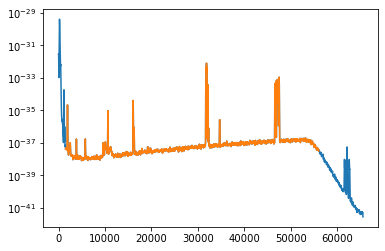

In [9]:
'''
Also with comparing to the LIGO noise seen in class, we only want the mid range frequences of this.
'''

# N = H_noise_gau[1500:56000] 
N_H = H_noise_gau.copy()

#but now my arrays are different lenghts, I guess I still need to add values for those I cut off - set to inf?
N_H[:1500] = np.inf
N_H[56000:] = np.inf

plt.semilogy(H_noise_gau, label="PS smoothed")
plt.semilogy(N_H, label="PS smoothed and cut")

### Now repeat for L data


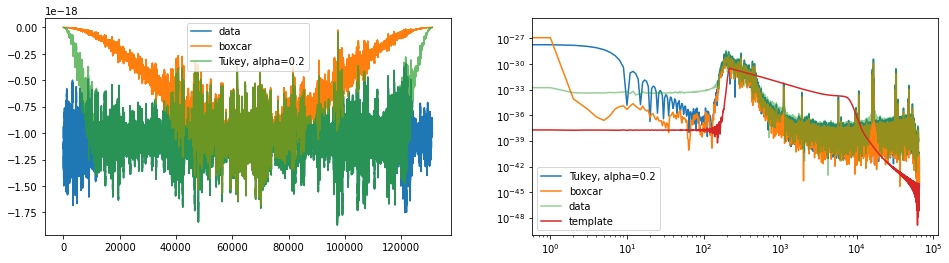

In [24]:
'''
first I want to window my data, tapering off the ends
I tried three functions for this, and the cosine-tapered window (Tukey) looked the best, 
not reducing the signal to much in the center, and still produced a similar power spectrum.

This data is now centered at 0, but around 1e-18, how to window thsis 
Maybe it's okay as I won't be looking at the edges anyways.

It does make some wierd

'''

fig, ax = plt.subplots(1, 2, figsize=(16,4))

alpha=0.2

strain_L_win = window(strain_L, n=alpha, Type="Tukey")

#need to window the signal as well
signal_win = window(tl, n=alpha, Type="Tukey")

ax[0].plot(strain_L, label='data')
ax[0].plot(window(strain_L), label='boxcar')
ax[0].plot(window(strain_L, n=alpha, Type="Tukey"), alpha=0.7, label='Tukey, alpha={}'.format(alpha))

ax[1].loglog(np.abs(np.fft.rfft(strain_L_win)**2), label='Tukey, alpha={}'.format(alpha))
ax[1].loglog(np.abs(np.fft.rfft(window(strain_L))**2), label='boxcar')
ax[1].loglog(np.abs(np.fft.rfft(strain_L)**2), label='data', alpha=0.5)


ax[1].loglog(np.abs(np.fft.rfft(signal_win)**2), label='template')

ax[0].legend()
ax[1].legend()

plt.show()

1.86118963933597e-31 9.850112720509651e-32


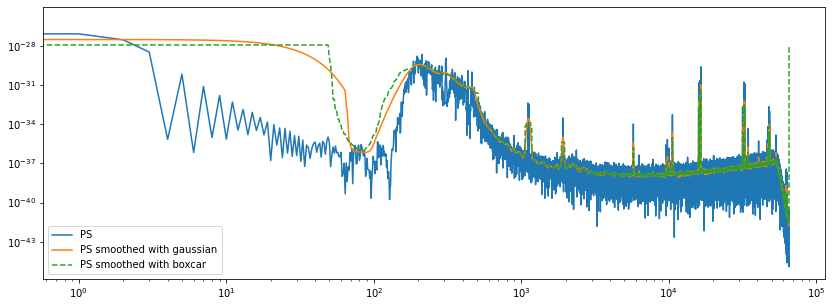

In [11]:
'''
For smoothing the noise (which is just the power spectrum of the windowed data), I decided to convolve with
a gaussian.

'''

alpha=0.5
strain_L_win = window(strain_L, n=alpha, Type="Tukey")

L_noise = noise(strain_L_win)
signal_win = window(tl, n=alpha, Type="Tukey")
# print(len(signal_win), len(H_noise))

#gaussian
L_noise_gau = smooth(L_noise, 15, 'gaussian')

print(np.mean(L_noise), np.mean(L_noise_gau))

plt.figure(figsize=(14,5))
plt.loglog(np.abs(np.fft.rfft(strain_L_win)**2), label="PS")
plt.loglog(L_noise_gau, label="PS smoothed with gaussian")

plt.loglog(smooth(L_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")

#this makes it worse, so maybe not
# plt.loglog(np.maximum(L_noise, L_noise_gau), ls="--", label="max of PS smoothed with boxcar")

plt.legend()
plt.show()

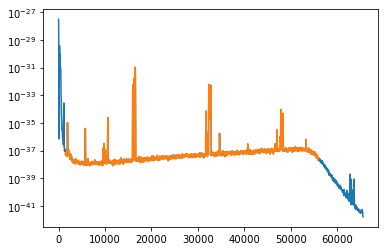

In [176]:
'''
Also with comparing to the LIGO noise seen in class, we only want the mid range frequences of this.
'''

# N = H_noise_gau[1500:56000] 
N_L = L_noise_gau.copy()
N_L[:1500] = np.inf
N_L[56000:] = np.inf

plt.semilogy(L_noise_gau, label="PS smoothed")
plt.semilogy(N_L, label="PS smoothed and cut")

[0. 0. 0. ... 0. 0. 0.]
65537 65537


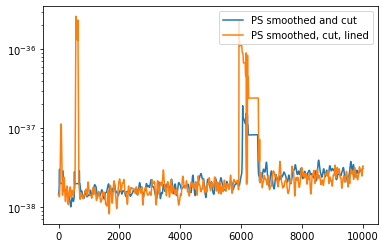

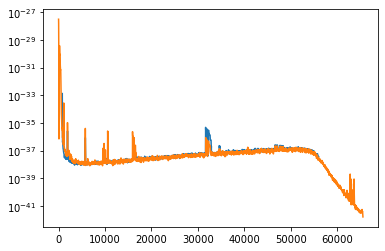

In [253]:
import numpy.ma as ma
""""
To remove lines if point is more than x times the ave of it's neightbors, set point to average
Using a masked array, so loop through once and mask out all values that should be removed, 
and then when calculating the average, this values are not used.
"""

#points to side to average over
sides = 8000

lines = np.zeros(len(L_noise_gau))

N_L_lines = L_noise_gau.copy()

for i in range(sides, len(L_noise_gau)-sides):
    ave = np.mean(L_noise_gau[i-sides:i+sides])
    
    if L_noise_gau[i] > ave*1.5:
        lines[i] = 1

#masking
masked = ma.masked_array(N_L_lines, mask=lines)
print(lines)

#and repeat omitting any of the outlier points from the averages
for i in range(sides, len(L_noise_gau)-sides):
   
    ave2 = np.mean(masked[i-sides:i+sides])
    
    if L_noise_gau[i] > ave2*2:
        N_L_lines[i] = ave2

print(np.count_nonzero(~np.isinf(lines)), len(lines))

plt.semilogy(N_L[10000:20000], label="PS smoothed and cut")
plt.semilogy(N_L_lines[10000:20000], label="PS smoothed, cut, lined")

plt.legend()
plt.show()

plt.semilogy(N_L, label="PS smoothed and cut")
plt.semilogy(N_L_lines, label="PS smoothed and cut")

In [254]:
"""
I decided not to remove the lines, as (at least for they way I was doing it), this made the 
noise to signal ratio worst, especially for the Livingston data.
"""
def removelines(noise_gau, sides = 4000):
    
    lines = np.zeros(len(noise_gau))

    N_L_lines = noise_gau.copy()

    for i in range(sides, len(noise_gau)-sides):
        ave = np.mean(noise_gau[i-sides:i+sides])

        if noise_gau[i] > ave*1.5:
            lines[i] = 1

    #masking
    masked = ma.masked_array(N_L_lines, mask=lines)

    #and repeat omitting any of the outlier points from the averages
    for i in range(sides, len(noise_gau)-sides):

        ave2 = np.mean(masked[i-sides:i+sides])

        if noise_gau[i] > ave2*1.5:
            N_L_lines[i] = ave2
        
    return N_L_lines

In [263]:
#now making a big function that will do all of this for the other data sets

def getNoiseModel(event, winAlpha=[0.5, 0.5], gauSig=[50,50], sides = 4000):
    print("For event "+events[event])
    
    #get data
    H1, L1, template = getData(event)
    strain_H,dt_H,utc_H = H1
    strain_L,dt_L,utc_L = L1
    th,tl = template
    
    #windowing
    strain_H_win = window(strain_H, n=winAlpha[0], Type="Tukey")
    signal_win_H = window(th, n=winAlpha[0], Type="Tukey")
    
    #get PS for noise
    H_noise = noise(strain_H_win)

    #smooth noise by gaussian convolution
    H_noise_gau = smooth(H_noise, gauSig[0], 'gaussian')
    
    #try to remove lines - omited
#     N_H = removelines(H_noise_gau, sides)
    N_H = H_noise_gau.copy()
    
    cutH = [800, 56000]
    N_H[:cutH[0]] = np.inf
    N_H[cutH[1]:] = np.inf
    
    #repeat for L data
    #windowing
    strain_L_win = window(strain_L, n=winAlpha[1], Type="Tukey")
    signal_win_L = window(tl, n=winAlpha[1], Type="Tukey")
    
    #get PS for noise
    L_noise = noise(strain_L_win)

    #smooth noise by gaussian convolution
    L_noise_gau = smooth(L_noise, gauSig[1], 'gaussian')
    
#     N_L = removelines(L_noise_gau, sides)
    N_L = L_noise_gau.copy()
    
    cutL = [800, 56000]
    N_L[:cutL[0]] = np.inf
    N_L[cutL[1]:] = np.inf
    
    fig, ax = plt.subplots(2, 2, figsize=(16,6))
    axs = ax.flatten()
    
    axs[0].set_title("Hanford PS")
    axs[0].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
    axs[0].loglog(H_noise_gau, label="PS smoothed with gaussian")
    axs[0].loglog(smooth(H_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")
    axs[0].loglog(np.abs(np.fft.rfft(signal_win_H)**2), label="Windowed template")

    axs[0].axvline(cutH[0], color='black', ls=":")
    axs[0].axvline(cutH[1], color='black', ls=":")

    axs[1].semilogy(H_noise_gau, label="PS smoothed")
    axs[1].semilogy(N_H, label="PS smoothed & cut")
#     axs[1].semilogy(N_H, label="PS smoothed, de-lined & cut")
    
    #Livingston detector
    axs[2].set_title("Livingston PS")
    axs[2].loglog(np.abs(np.fft.rfft(strain_H_win)**2), label="PS")
    axs[2].loglog(L_noise_gau, label="PS smoothed with gaussian")
    axs[2].loglog(smooth(L_noise, 50, 'boxcar'), ls="--", label="PS smoothed with boxcar")
    axs[2].loglog(np.abs(np.fft.rfft(signal_win_L)**2), label="Windowed template")
    axs[2].axvline(cutL[0], color='black', ls=":")
    axs[2].axvline(cutL[1], color='black', ls=":")
    
    axs[3].semilogy(L_noise_gau, label="PS smoothed")
    axs[3].semilogy(N_L, label="PS smoothed & cut")
#     axs[3].semilogy(N_L, label="PS smoothed, de-lined & cut")
    
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[3].legend()
    plt.tight_layout()
    plt.show()
    
    return [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L]

For event GW150914
reading file  H-H1_LOSC_4_V2-1126259446-32.hdf5


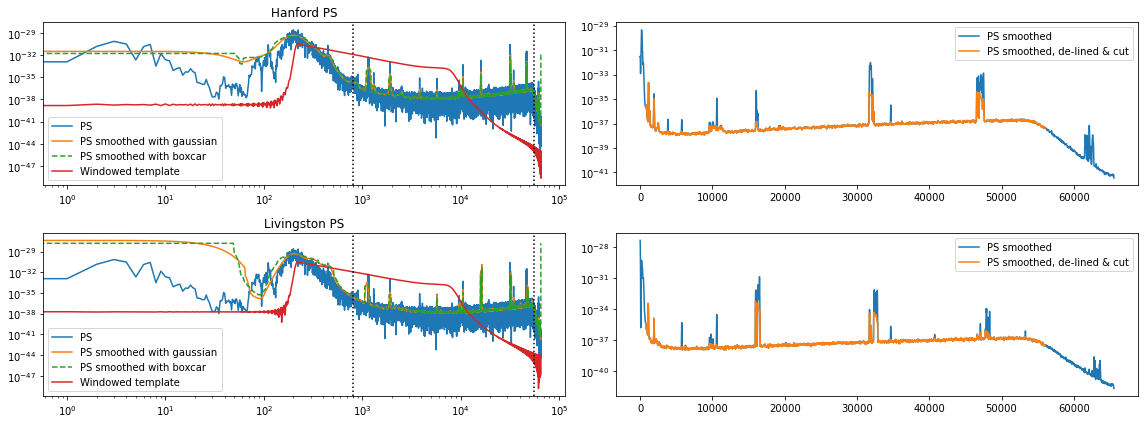

In [256]:
data0 = getNoiseModel(0, winAlpha=[0.2, 0.2], gauSig=[20,15])

For event GW151226
reading file  H-H1_LOSC_4_V2-1135136334-32.hdf5


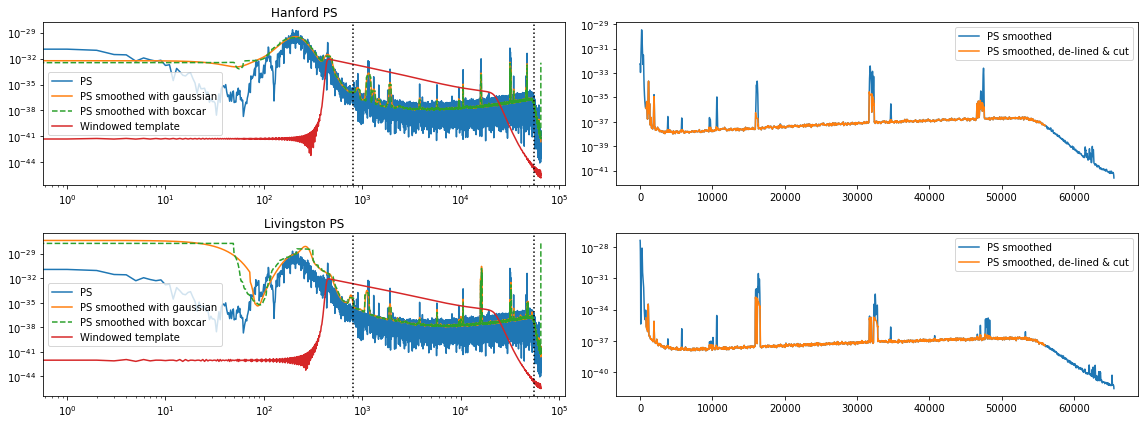

For event LVT151012
reading file  H-H1_LOSC_4_V2-1128678884-32.hdf5


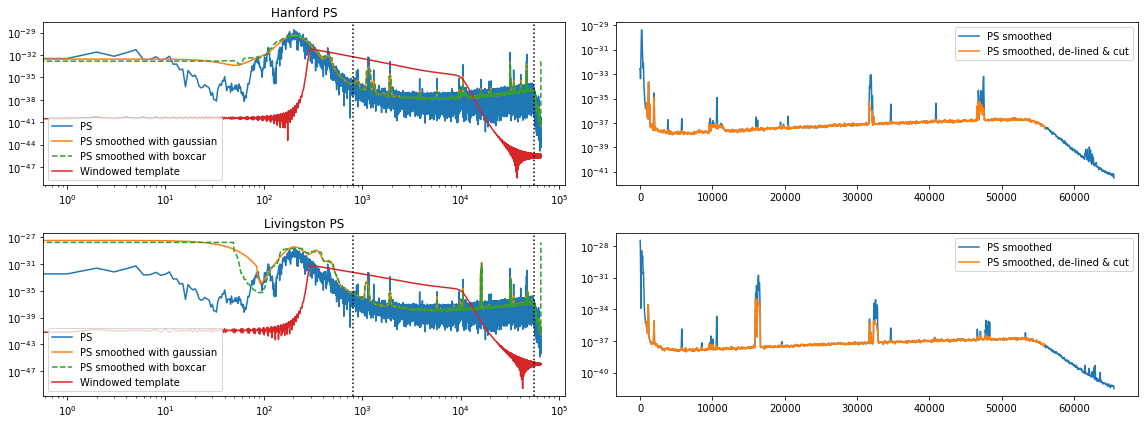

For event GW170104
reading file  H-H1_LOSC_4_V1-1167559920-32.hdf5


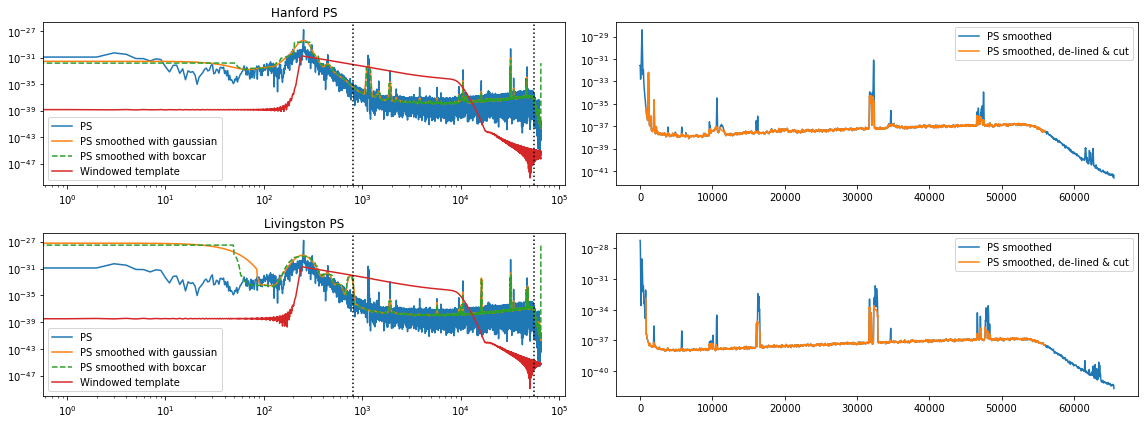

In [257]:
data1 = getNoiseModel(1, winAlpha=[0.2, 0.2], gauSig=[23,17])
data2 = getNoiseModel(2, winAlpha=[0.2, 0.2], gauSig=[20,20])
data3 = getNoiseModel(3, winAlpha=[0.2, 0.2], gauSig=[20,20])

dataAll = [data0, data1, data2, data3]

b) Use that noise model to search the four sets of events using a matched
filter. The mapping between data and templates can be found in the file BBH events v3.json, included in the zipfile. 

In [258]:
#match fliter function
def matchFilter(data, template, N=0):
    if isinstance(N, int):#no noise matrix
        mf = np.fft.irfft(np.fft.rfft(data)*np.conj(np.fft.rfft(template)))
    else :#assume noise is is correct PS form
        mf = np.fft.irfft((np.fft.rfft(data)/N)*np.conj(np.fft.rfft(template)))
    return mf

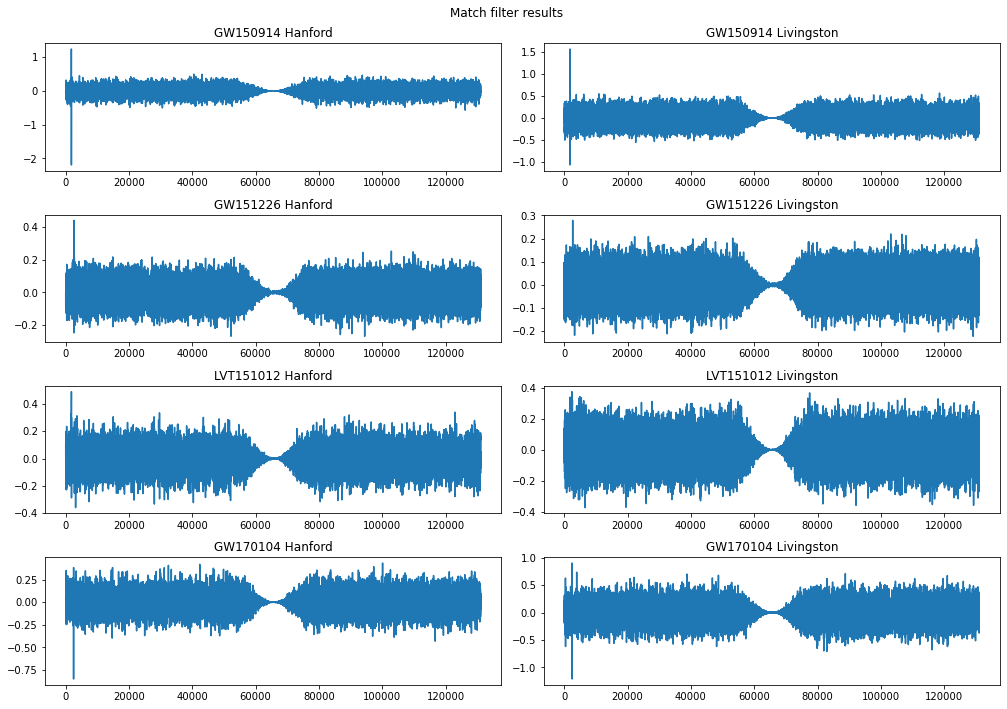

In [259]:
"""
whitening - use N^-1/2 A and N^-1/2 d for the template and strain for running the matched filter.
this will help as then the noise is uncorrelated and not create peaks on the match filter, 
leaving (hopefully) only the true signal to match
"""

data_white = []
MFs = []

fig, ax = plt.subplots(4, 2, figsize=(14,10))
axs = ax.flatten()

fig.suptitle("Match filter results")
i=0
for data in dataAll:
    
    [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L] = data
    
    strain_H_whit = np.fft.irfft((N_H**-0.5)*np.fft.rfft(strain_H_win), len(strain_H_win))
    signal_H_whit = np.fft.irfft((N_H**-0.5)*np.fft.rfft(signal_win_H), len(signal_win_H))
    
    strain_L_whit = np.fft.irfft((N_L**-0.5)*np.fft.rfft(strain_L_win), len(strain_L_win))
    signal_L_whit = np.fft.irfft((N_L**-0.5)*np.fft.rfft(signal_win_L), len(signal_win_L))

    
    mf_H = matchFilter(strain_H_whit, signal_H_whit)
    mf_L = matchFilter(strain_L_whit, signal_L_whit)
    
    axs[i].set_title("{} Hanford".format(events[int(i/2)]))
    axs[i].plot(mf_H)
    
    axs[i+1].set_title("{} Livingston".format(events[int(i/2)]))
    axs[i+1].plot(mf_L)
    i=i+2
    
    MFs.append([mf_H, mf_L])
    data_white.append([[strain_H_whit, signal_H_whit],[strain_L_whit, signal_L_whit]])

plt.tight_layout()
plt.show()

#other events don't have a great ratio

### c) 
Estimate a noise for each event, and from the output of the matched
filter, give a signal-to-noise ratio for each event, both from the individual detectors, and from the combined Livingston + Hanford events. 

In [260]:
#get noise and signal to noise ratio for each event
sigToNoise = []

for i, data in enumerate(dataAll):
    print(events[i])

    #take noise as the std in the match fliter - use areas where noise is correctly large 
    # -> not the small bit from the windowing
    noiseEst_H = np.std(MFs[i][0][10000:50000])
    noiseEst_L = np.std(MFs[i][1][10000:50000])

    sigToNoise_H = np.max(np.abs(MFs[i][0]))/noiseEst_H #take range of mfdata for noise?
    sigToNoise_L = np.max(np.abs(MFs[i][1]))/noiseEst_L #take range of mfdata for noise?

    print("Hanford noise estimate: {:.5}, signal to noise ratio: {:.5}".format(noiseEst_H, sigToNoise_H))
    print("Livingston noise estimate: {:.5}, signal to noise ratio: {:.5}".format(noiseEst_L, sigToNoise_L))
    print("Total signal to noise ratio: {:.5}\n".format((sigToNoise_H+sigToNoise_L)/2))
    
    sigToNoise.append([sigToNoise_H, sigToNoise_L])

#for both detectors, average between two?

GW150914
Hanford noise estimate: 0.13191, signal to noise ratio: 16.614
Livingston noise estimate: 0.16867, signal to noise ratio: 9.2934
Total signal to noise ratio: 12.954

GW151226
Hanford noise estimate: 0.061724, signal to noise ratio: 7.1616
Livingston noise estimate: 0.057622, signal to noise ratio: 4.8325
Total signal to noise ratio: 5.9971

LVT151012
Hanford noise estimate: 0.082874, signal to noise ratio: 5.8924
Livingston noise estimate: 0.093779, signal to noise ratio: 3.9982
Total signal to noise ratio: 4.9453

GW170104
Hanford noise estimate: 0.10152, signal to noise ratio: 8.3529
Livingston noise estimate: 0.1798, signal to noise ratio: 6.7365
Total signal to noise ratio: 7.5447



### d) 
Compare the signal-to-noise you get from the scatter in the matched
filter to the analytic signal-to-noise you expect from your noise model. How close are they? If they disagree, can you explain why? 

$m / \sigma_m= \frac{data}{noise}$

$ \sigma_m=\sqrt{(A^TN^{-1}A)^{-1}}$

With our pre-whiten template, N is diagonal and $\tilde{A} = N^{-1/2}A$, using this $\tilde{A}^T = (N^{-1/2}A)^T = A^T (N^{-1/2})^T$, 
$
A=N^{-1/2}\tilde{A} ~~\&~~ A^T=\tilde{A}^T (N^{-1/2})^T \\
A^TN^{-1}A = \tilde{A}^T (N^{-1/2})^T N^{-1} N^{-1/2}\tilde{A} \\
= \tilde{A}^T (N^{-1/2})^T N^{-1/2} N^{-1/2} N^{-1/2}\tilde{A}  ~~\text{N is symmetric}\\
= \tilde{A}^T (N^{-1/2})^T N^{-1/2} (N^{-1/2})^T N^{-1/2}\tilde{A}\\
= \tilde{A}^T \tilde{A} ~~\text{But our A's are 1D, so this is simply}\\
= \tilde{A}^2
$

$ \sigma_m=\sqrt{(A)^{-2}}$



m is simply our matched filter, and the noise needs to be the noise on the model -> so on the template. Using whitened template as here the noise should be diagonal and therefore taking it as the std.

sigma_m: 0.11496, SNR H: 18.505, SNR L: 11.969
sigma_m: 0.049852, SNR H: 9.7354, SNR L: 4.6624
sigma_m: 0.073974, SNR H: 6.8384, SNR L: 5.0178
sigma_m: 0.09449, SNR H: 8.688, SNR L: 10.746


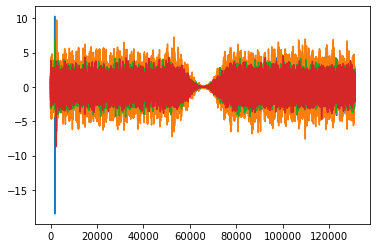

In [246]:
for i, data in enumerate(dataAll):
    [strain_H_win, signal_win_H, N_H], [strain_L_win, signal_win_L, N_L] = data

    # data_white
    signal_win_H_white = data_white[i][0][1]

    # sigToNoise
#     plt.plot(signal_win_H)
#     plt.show()
#     plt.plot(signal_win_H_white)
#     plt.show()

    sigma = np.sqrt(np.mean(signal_win_H_white**2))
#     which is really the same as np.std(signal_win_H_white)

    #mf / noise on model
    SNR_H = MFs[i][0]/sigma
    SNR_L= MFs[i][1]/sigma

    plt.plot(SNR_H)

    print("sigma_m: {:.5}, SNR H: {:.5}, SNR L: {:.5}".format(sigma, np.abs(SNR_H).max(), np.abs(SNR_L).max()))
plt.show()

In [20]:
#compare

# for i, data in enumerate(dataAll):
    
#     print("SNR H: {:.5}, SNR L: {:.5}".format(sigma, np.abs(SNR_H).max(), np.abs(SNR_L).max()))


e) From the template and noise model, find the frequency from each event
where half the weight comes from above that frequency and half below. 

In [247]:
#get frequency
# dt in sec  -> want Hz

# print(dt_H,dt_L) #they are all the same
time = np.arange(0, len(strain_H))*dt_H
# print(time)

samp_rate = 1.0/dt_H
print(samp_rate) #matches fs in json file

freqs = np.arange(0, len(strain_H))*(samp_rate/len(strain_H))
# print(freqs)
freqs = freqs[:int(len(strain_H)/2+1)] #only take the first half of the values to match my rfft lengths


4096.0


110.75
119.34375
87.53125
109.78125
88.15625
99.5
102.78125
77.125


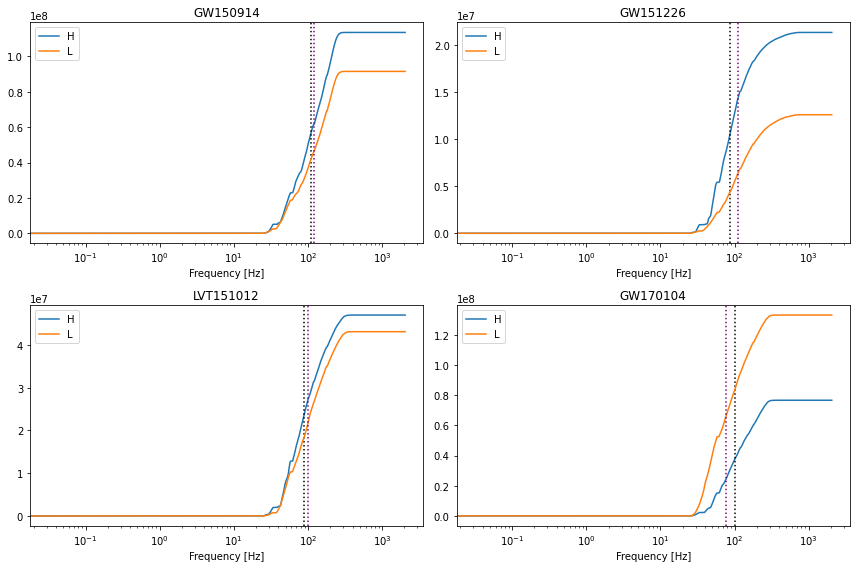

In [248]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

fig, ax = plt.subplots(2, 2, figsize=(12,8))
axs = ax.flatten()

for j, data in enumerate(data_white):
    [[strain_H_whit, signal_H_whit],[strain_L_whit, signal_L_whit]] = data

    signal_H_white_ps = np.abs(np.fft.rfft(signal_H_whit)**2)

    TotalWeight = np.zeros(len(signal_H_white_ps))
    TotalWeight[0] = signal_H_white_ps[0]
    
    #get cumulative weight at each point
    for i in range(1, len(signal_H_white_ps)):
        TotalWeight[i] = signal_H_white_ps[i] + TotalWeight[i-1]

    half = TotalWeight[-1]/2
    
    halfPointVal, halfPoint = find_nearest(TotalWeight, half)
    
    axs[j].set_title(events[j])
    axs[j].semilogx(freqs, TotalWeight, label="H")
    axs[j].axvline(freqs[halfPoint], ls=":", color='black')
    print(freqs[halfPoint])

    
    #repeat for L
    signal_L_white_ps = np.abs(np.fft.rfft(signal_L_whit)**2)

    TotalWeight = np.zeros(len(signal_L_white_ps))
    TotalWeight[0] = signal_L_white_ps[0]
    
    #get cumulative weight at each point
    for i in range(1, len(signal_L_white_ps)):
        TotalWeight[i] = signal_L_white_ps[i] + TotalWeight[i-1]

    half = TotalWeight[-1]/2
    
    halfPointVal, halfPoint = find_nearest(TotalWeight, half)
    
    axs[j].semilogx(freqs, TotalWeight, label="L")
    axs[j].axvline(freqs[halfPoint], ls=":", color='purple')
    axs[j].set_xlabel("Frequency [Hz]")
    
    axs[j].legend()
    print(freqs[halfPoint])

plt.tight_layout()
plt.show()   

f) How well can you localize the time of arrival (the horizontal shift of your matched filter). The positions of gravitational wave events are inferred by comparing their arrival times at different detectors. What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?

diff with abs: 8.789e-03
diff with fit: 6.903e-03
sigmas: H:2.38899e-03, L:3.18793e-03
diff with abs: 4.883e-04
diff with fit: 6.086e+03
sigmas: H:5.07833e-03, L:3.98203e+03
diff with abs: 1.465e-03
diff with fit: 4.973e+03
sigmas: H:2.45909e+03, L:1.98558e-03
diff with abs: 4.639e-03
diff with fit: 3.356e-03
sigmas: H:4.53624e-03, L:9.72060e-04


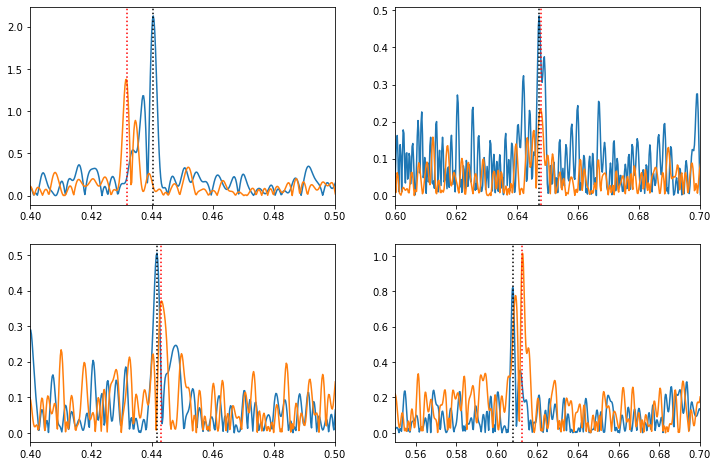

In [249]:
#should I look at MF or STN?

# need time on axis

i=0
fig, ax = plt.subplots(2, 2, figsize=(12,8))
axs = ax.flatten()

#zoom in and look
xlims = [[0.4, 0.5], [0.6, 0.7], [0.4, 0.5], [0.55, 0.7]]
maxes = []

for i, data in enumerate(data_white):

    #as I have a clear singular min and max for the mf, look between those 2 values?
    
    max2_H = np.argmax(np.abs(MFs[i][0]))
    max2_L = np.argmax(np.abs(MFs[i][1]))
    maxes.append([max2_H, max2_L])
    
    #fit a gaussian for error - popt = [a, x0, sigma]
    popt_H, pcov = curve_fit(gauss_function, time, np.abs(MFs[i][0]), p0 = [1, time[max2_H], 0.002])
    popt_L, pcov = curve_fit(gauss_function, time, np.abs(MFs[i][1]), p0 = [1, time[max2_L], 0.002])

    print("diff with abs: {:.3e}".format(np.abs(time[max2_H]-time[max2_L])))
    print("diff with fit: {:.3e}".format(np.abs(popt_L[1]-popt_H[1])))
    print("sigmas: H:{:.5e}, L:{:.5e}".format(popt_L[2], popt_H[2]))
    
    
#     print("diff with ave: {:.3e}".format(np.abs( np.abs(time[max_H]-time[min_H])/2.0 - np.abs(time[max_L]-time[min_L])/2.0 )))
#     print()

    axs[i].plot(time, np.abs(MFs[i][0]))
    axs[i].plot(time, np.abs(MFs[i][1]))
#     axs[i].axvline(time[min_H], ls=":", color='black')
    axs[i].axvline(time[max2_H], ls=":", color='black')

    axs[i].axvline(time[max2_L], ls=":", color='red')
#     axs[i].axvline(time[min_L], ls=":", color='red')

    # plt.xlim(1000, 2500)
    axs[i].set_xlim(xlims[i][0], xlims[i][1])

plt.show()

In [159]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

from scipy.optimize import curve_fit

[0.96242644 0.43229762 0.00240018]


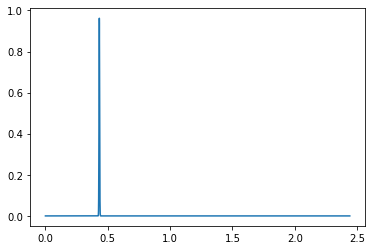

[0.13471301 0.64666985 0.00389122]


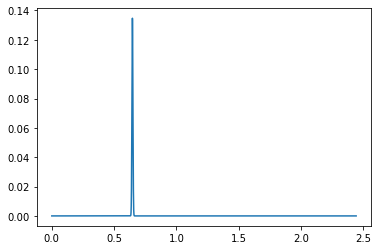

[0.06887961 1.15616649 1.86927904]


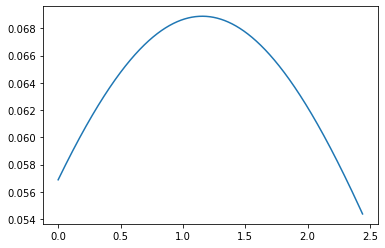

[0.6750965  0.61113497 0.00451598]


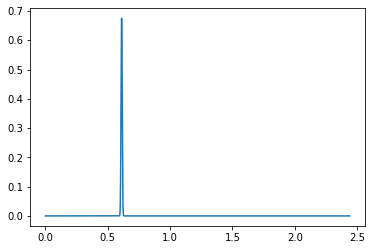

In [163]:
# maxes
i=0
# a, x0, sigma

#third event isn't fitting for L
for i, data in enumerate(data_white):
    popt, pcov = curve_fit(gauss_function, time[0:10000], np.abs(MFs[i][1])[0:10000], p0 = [1, time[maxes[i][1]], 0.002])

    plt.plot(time[0:10000], gauss_function(time[0:10000], *popt), label='fit')
    print(popt)
    plt.show()

*What is the typical positional uncertainy you might expect given that the detectors area a few thousand km apart?*

error on timing ~0.0003

distance ~1e3, c=3e8




